In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from PrepareSensorData import get_mag_df, get_coordinate_dicts
from OptimizedSelection import get_optimized_sensors
from LazySelections import random_selection, greedy_geographic_selection, greedy_variance_selection
from makeModel import df_to_X_y, buildModel, trainModel

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load filtered data, compute optimized sensor selection as well as 3 lazy sensor selections

In [6]:
x_km_from_turbines = 5
k = 10
df_mag = get_mag_df(x_km_from_turbines) #this function will fetch the filtered data if it exists otherwise it will create and locally save the filtered data for next time 
lat_dict, lon_dict = get_coordinate_dicts(df_mag)

lazy_random_selection = random_selection(list(df_mag.columns), k=k)
lazy_geographic_selection = greedy_geographic_selection(list(df_mag.columns.astype(int)), lat_dict, lon_dict, k=k)
df_mag_sqrt = np.sqrt(df_mag)
df_mag_sqrt.columns = df_mag_sqrt.columns.astype(int)
lazy_variance_selection = greedy_variance_selection(df_mag_sqrt, k=k)

optimal_selection = get_optimized_sensors(df_mag_sqrt,k=k)
print('Submodular Greedy Selection:')
for index in optimal_selection:
    print(f"Sensor {index} coordinates: ({lat_dict[index]}, {lon_dict[index]})")


Looking for file at data/filtered_historicalForecasts/5km_historicalForecast2024.csv... FOUND!

Submodular Greedy Selection:
Sensor 10077 coordinates: (43.131934562, -74.9285066354)
Sensor 3149 coordinates: (42.132934562, -77.7665066354)
Sensor 4500 coordinates: (42.321934562, -77.5025066354)
Sensor 4797 coordinates: (42.348934562, -74.0705066354)
Sensor 17339 coordinates: (44.913934562, -74.1365066354)
Sensor 3025 coordinates: (42.105934562, -75.5885066354)
Sensor 9000 coordinates: (42.969934562, -75.4895066354)
Sensor 4497 coordinates: (42.321934562, -77.6015066354)
Sensor 3151 coordinates: (42.132934562, -77.7005066354)
Sensor 7532 coordinates: (42.753934562, -78.1625066354)


# Next steps

In [7]:

energy = pd.read_csv('data/historical_energy.csv')

def dateparser(date_str):
    # Adjust the timezone offset format to ISO 8601 (from -05 to -05:00)
    date_str = str(date_str).strip()
    date_str = date_str + ":00"  # Insert the colon in the timezone offset
    date = pd.to_datetime(date_str, format="%Y-%m-%dT%H%z").tz_convert("America/New_York")
    return date

energy['period'] =  energy["period"].astype(str).str.strip().apply(dateparser)

start_ny = pd.Timestamp('2024-01-01', tz='America/New_York')
end_ny = pd.Timestamp('2024-12-31', tz='America/New_York')
energy = energy[(energy['period'] >= start_ny) & (energy['period'] < end_ny)]
energy = energy.set_index('period')

Epoch 1/100
200/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8824 - root_mean_squared_error: 0.9392
Epoch 1: val_loss improved from inf to 1.61432, saving model to models/lstm_optimized.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8811 - root_mean_squared_error: 0.9386 - val_loss: 1.6143 - val_root_mean_squared_error: 1.2706
Epoch 2/100
209/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8888 - root_mean_squared_error: 0.9426
Epoch 2: val_loss did not improve from 1.61432
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8880 - root_mean_squared_error: 0.9421 - val_loss: 1.6660 - val_root_mean_squared_error: 1.2907
Epoch 3/100
209/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8926 - root_mean_squared_error: 0.9447
Epoch 3: val_loss did not improve from 1.61432
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8915 - root_mean_squared_error: 0.9441 - val_loss: 1.6176 - val_root_mean_squared_error: 1.2718
Epoch 4/100
211/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8583

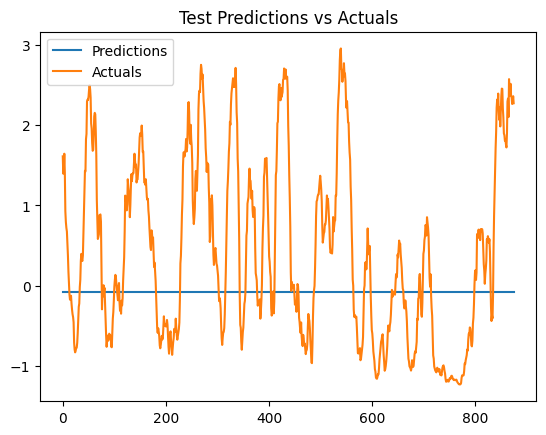

In [41]:
# Preprocessing data
# Reset the index of energy (which becomes RangeIndex)
energy = energy.reset_index(drop=True)

# Remove timezone from df_mag_sqrt index
df_mag_sqrt.index = df_mag_sqrt.index.tz_localize(None)

# Concatenate the dataframes, now with unique and aligned indices
df_combined = pd.concat([df_mag_sqrt[optimal_selection], energy['Megawatthours']], axis=1)

# Forward fill missing values
df_combined = df_combined.ffill()

# Drop any remaining NaNs just in case (e.g., at the very beginning)
df_combined = df_combined.dropna()

# Split back into features and target
X_df = df_combined[optimal_selection]
y_df = df_combined['Megawatthours']

# Normalize/Scale the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df)

# Scale the target variable
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_df.values.reshape(-1, 1))

# Create LSTM-ready sequences
X, y = df_to_X_y(X_scaled, y_scaled, window_size=24)

# Build the model
model = buildModel(X)

# Show model architecture
#model.summary()

# Train the model and evaluate on the test set
results, mse_score = trainModel(
    model,
    model_name="models/lstm_optimized.keras",
    X=X,
    y=y
)